In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

2022-12-03 02:55:05.744129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 02:55:06.602591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 02:55:06.602604: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 02:55:08.941898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
pre_trained_model = InceptionV3(input_shape = (299,299,3),
                               include_top  = False,
                               weights      = 'imagenet')

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
      layer.trainable = False

# Print the model summary
pre_trained_model.summary()

2022-12-03 02:55:12.475404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-03 02:55:12.475437: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 02:55:12.475451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (red): /proc/driver/nvidia/version does not exist
2022-12-03 02:55:12.476297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output



# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation = 'sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

model.summary()


last layer output shape:  (None, 17, 17, 768)


2022-12-03 02:55:20.254299: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 909115392 exceeds 10% of free system memory.
2022-12-03 02:55:20.425112: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 909115392 exceeds 10% of free system memory.
2022-12-03 02:55:22.152985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 909115392 exceeds 10% of free system memory.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:



train_dir = '/home/red/Documents/SkinDisease/dataset/archive/dataset_categorized_final_split/train'
validation_dir = '/home/red/Documents/SkinDisease/dataset/archive/dataset_categorized_final_split/test'


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,  # This is the source directory for training images
        target_size=(299,299), 
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,  # This is the source directory for training images
        target_size=(299,299), 
        batch_size=32,
        class_mode='categorical')

Found 24855 images belonging to 23 classes.
Found 4317 images belonging to 23 classes.


In [6]:


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True




# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99% accuracy

callbacks = myCallback()

In [7]:
history = model.fit_generator(train_generator,
                             validation_data = validation_generator,
                             steps_per_epoch = 10,
                             epochs = 3,
                             validation_steps = 10,
                             verbose = 1,
                             callbacks=[callbacks])

/tmp/ipykernel_28300/1838659469.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/3


2022-12-03 02:55:38.414659: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 909115392 exceeds 10% of free system memory.
2022-12-03 02:55:39.733213: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 909115392 exceeds 10% of free system memory.


10/10 [==============================] - 104s 6s/step - loss: 0.0000e+00 - acc: 0.0700 - val_loss: 3.1355 - val_acc: 0.0435
Epoch 2/3
10/10 [==============================] - 48s 4s/step - loss: 0.0000e+00 - acc: 0.0450 - val_loss: 3.1355 - val_acc: 0.0435
Epoch 3/3
10/10 [==============================] - 46s 4s/step - loss: 0.0000e+00 - acc: 0.0650 - val_loss: 3.1355 - val_acc: 0.0435


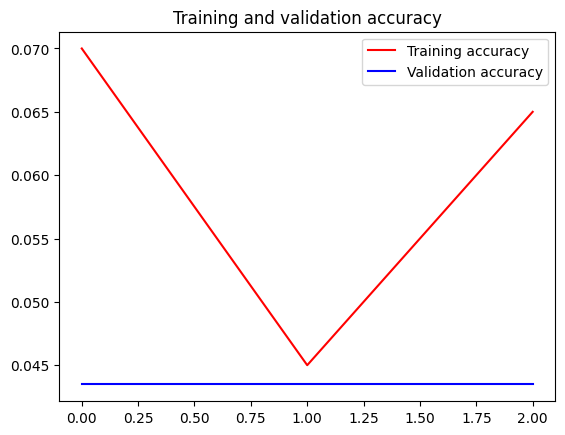

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()
     